#  `Cobaya` in `lenstronomy`
<b>Author</b>: Natalie B. Hogg

This notebook demonstrates how to use [`Cobaya`](https://cobaya.readthedocs.io/en/latest/index.html) for strong lens model fitting with [`lenstronomy`](https://lenstronomy.readthedocs.io/en/latest/). 

It assumes some familiarity with Bayesian sampling methods and strong lens modelling.

## Contents
<a name="contents"></a>
1. [Introduction](#intro)
2. [Set up](#setup)
3. [Create the lens](#create_lens)
4. [Create the image](#create_image)
5. [Fit the image](#analyse_image)
6. [Result](#contour)

## Introduction <a name="intro"></a>

Let us begin by noting that `Cobaya` is actually a complete Python interface for cosmological Boltzmann solvers (`CAMB`, `CLASS`) and multiple sampling packages. In this notebook, I use "`Cobaya`" as a shorthand for the [pure Metropolis--Hastings MCMC sampler](https://cobaya.readthedocs.io/en/latest/sampler_mcmc.html) provided by the package. This MCMC sampler employs the same "fast dragging" algorithm as that in `CosmoMC` and `Montepython`, though the fast/slow parameter hierarchy is currently not available in the `lenstronomy` implementation.

### Current status of sampling methods in `lenstronomy`
Up to and including `v1.11.1`, the available sampling methods in `lenstronomy` fall into two broad classes: ensemble MCMC methods (`emcee` and `zeus`) and nested sampling methods (`polychord`, `dynesty`, `multinest`). 

- Ensemble MCMC methods explore the parameter space using an ensemble of so-called "walkers". The walkers' positions are not independent; in a typical ensemble MCMC algorithm, the position of each walker will be updated based on the positions of all the other walkers.

- Nested sampling methods do not work by constructing a Markov chain. Instead, the prior volume is populated with a collection of "live" points. The point with the lowest probability is identified

The pure Metropolis--Hastings MCMC method of `Cobaya` is a third distinct sampling method, and one which predates both of the above classes of methods.

### Why use `Cobaya`?
There are (at least) three reasons why you should consider using `Cobaya` :
1. Ensemble methods are doomed to fail in high dimensions.
2. Convergence statistics like the Gelman--Rubin criterion ($R-1$) are more easily and safely evaluated since the chains are independent.
3. `Cobaya` produces a much more useful collection of output products beyond the MCMC samples; especially useful is the covariance matrix which can be used to initialise future runs, as I will demonstrate later in this notebook. It is also more informative than `emcee` while it is running.

### Bibliography

## Set up <a name="setup"></a>

In [1]:
import numpy as np
from matplotlib import rc, rcParams, rcParamsDefault, pyplot as plt
import getdist.plots as gdplt
import os

# lenstronomy
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.SimulationAPI.ObservationConfig.HST import HST
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# use TeX
rc('text', usetex=True)
rc('font', family='serif')
rcParams.update({'font.size': 18})

outpath = 'chains/my_first_cobaya_chain'

## Create the lens <a name="create_lens"></a>

[Back to contents](#contents)

In [2]:
# source model
source_model_list = ['SERSIC']

magnitude_source = 24.0
R_sersic_source = 0.3
n_sersic_source = 3.0
x_source = 0.1
y_source = 0.1

kwargs_sersic = {'magnitude': magnitude_source,
                 'R_sersic': R_sersic_source, 
                 'n_sersic': n_sersic_source, 
                 'center_x': x_source, 
                 'center_y': y_source}

kwargs_source = [kwargs_sersic]

In [3]:
# lens model
lens_model_list = ['SIS', 'LOS_MINIMAL']

theta_E = 1.5
x_lens = 0.0
y_lens = 0.0

kwargs_sis = {'theta_E': theta_E,
              'center_x': x_lens,
              'center_y': y_lens}

kwargs_los = {'gamma1_od': 0.01, 'gamma2_od': 0.01, 'kappa_od': 0.0, 'omega_od': 0.0,
              'gamma1_los': -0.02, 'gamma2_los': -0.03, 'kappa_los': 0.0, 'omega_los': 0.0}

In [4]:
kwargs_lens = [kwargs_sis, kwargs_los]

kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list}

## Create the image <a name="create_image"></a>

[Back to contents](#contents)

In [5]:
# get the telescope settings for HST
psf = 'GAUSSIAN'
band = HST(band='WFC3_F160W', psf_type=psf) # this chooses the specific camera and filter of HST
kwargs_band = band.kwargs_single_band() # we are only considering a single band (i.e. a single wavelength/filter)
pixel_size = band.camera['pixel_scale'] # in arcsec

kwargs_psf = {'psf_type': psf,
              'fwhm': kwargs_band['seeing'],
              'pixel_size': pixel_size,
              'truncation': 3}

# define the numerics
kwargs_numerics = {'supersampling_factor': 1,
                   'supersampling_convolution': False}

# call the simulation API class
sim = SimAPI(numpix = 60, # number of pixels we want in our image
             kwargs_single_band = kwargs_band, # give the SimAPI class the keyword arguments for HST that we got above
             kwargs_model = kwargs_model)

kwargs_data = sim.kwargs_data

In [6]:
# convert magnitudes into amplitudes
# we don't care about lens light or point source here
ll, kwargs_source, ps = sim.magnitude2amplitude(kwargs_source_mag=kwargs_source)

In [7]:
# now use the SimAPI class to generate a noisy image in one step
imSim = sim.image_model_class(kwargs_numerics)

image = imSim.image(kwargs_lens = kwargs_lens,
                    kwargs_source = kwargs_source)

image_noisy = image + sim.noise_for_model(model = image)

kwargs_data['image_data'] = image_noisy

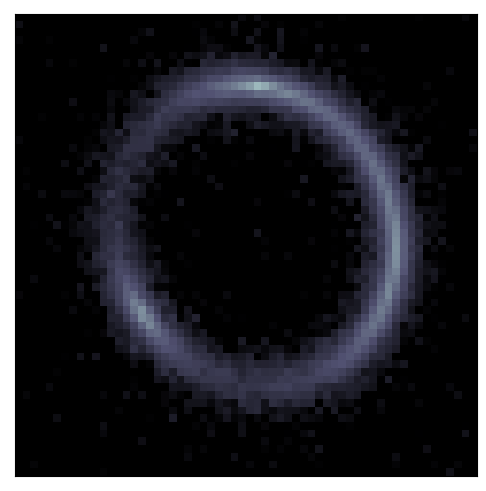

In [8]:
# plot the image
cmap_string = 'bone'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -2
v_max = 1

f, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
im = ax.matshow(np.log10(image_noisy), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()

## Fit the image  <a name="analyse_image"></a>

[Back to contents](#contents)

In [9]:
# LENS MODEL

lens_model_list = ['SIS', 'LOS_MINIMAL']

# Initialise the lists of parameters
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({'center_x': x_lens, 'center_y': y_lens})
kwargs_lens_init.append({'theta_E': theta_E})
# kwargs_lens_sigma.append({'theta_E': 0.1}) # what happens if you pass None here? cobaya doesnt need them
kwargs_lower_lens.append({'theta_E': 1.0})
kwargs_upper_lens.append({'theta_E': 3.0})

params = ['gamma1_od', 'gamma2_od', 'gamma1_los', 'gamma2_los']

fixed_lens.append({'kappa_od': 0.0, 'omega_od': 0.0, 'kappa_los': 0.0, 'omega_los': 0.0})
kwargs_lens_init.append({'gamma1_od': kwargs_los['gamma1_od'], 'gamma2_od': kwargs_los['gamma2_od'],
                        'gamma1_los': kwargs_los['gamma1_los'], 'gamma2_los': kwargs_los['gamma2_los']})

# kwargs_lens_sigma.append({param: 0.1 for param in params})
kwargs_lower_lens.append({param: -0.5 for param in params})
kwargs_upper_lens.append({param: 0.5 for param in params})

lens_params = [kwargs_lens_init,
               kwargs_lens_sigma,
               fixed_lens,
               kwargs_lower_lens,
               kwargs_upper_lens]

# SOURCE MODEL

source_model_list = ['SERSIC']

# Initialise the lists of parameters
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


# Define parameters
fixed_source.append({})
kwargs_source_init.append({'center_x': x_source,
                           'center_y': y_source,
                           'R_sersic': R_sersic_source, 
                           'n_sersic': n_sersic_source})

# kwargs_source_sigma.append({'center_x': 0.01, 'center_y': 0.01,
#                             'R_sersic': 0.1, 'n_sersic': 0.1})

kwargs_lower_source.append({'center_x': -1.0, 'center_y': -1.0,
                            'R_sersic': 0.0, 'n_sersic': 0.0})

kwargs_upper_source.append({'center_x': 1.0, 'center_y': 1.0,
                            'R_sersic': 10.0, 'n_sersic': 6.0})

source_params = [kwargs_source_init, kwargs_source_sigma,
                 fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params}

In [10]:
kwargs_likelihood = {'source_marg': True}

kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {'multi_band_list': multi_band_list,
                     'multi_band_type': 'multi-linear'}

kwargs_constraints = {}

In [11]:
labels = [# SIS
          r'$\theta_{\rm E}$',
          # LOS
          r'$\gamma_1^{\rm od}$',
          r'$\gamma_2^{\rm od}$',
          r'$\gamma_1^{\rm LOS}$',
          r'$\gamma_2^{\rm LOS}$',
          # source
          r'$R_{\rm S\acute{e}rsic}$',
          r'$n_{\rm S\acute{e}rsic}$',
          r'$x_{\rm source}$',
          r'$y_{\rm source}$']

expected_values = [# SIS
                   kwargs_sis['theta_E'],
                   # LOS
                   kwargs_los['gamma1_od'],
                   kwargs_los['gamma2_od'],
                   kwargs_los['gamma1_los'],
                   kwargs_los['gamma1_los'],
                   # source
                   kwargs_sersic['R_sersic'],
                   kwargs_sersic['n_sersic'],
                   kwargs_sersic['center_x'],
                   kwargs_sersic['center_y']]

proposals = [0.001]*len(labels)

In [13]:
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, 
                              kwargs_likelihood, kwargs_params)

kwargs_cobaya = {'starting_points': expected_values,
                 'proposal_widths': proposals,
                 'latex': labels,
                 'covmat': 'chains/test_mpi_script.covmat',
                 'Rminus1_stop': 10,
                 'path': outpath, # saves the chain file 'test.1.txt' to the 'chains' folder
                 'force_overwrite': True}

fitting_kwargs_list = [['metropolis_hastings', kwargs_cobaya]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)

kwargs_result = chain_list[0][2]

Using the Metropolis--Hastings MCMC sampler in Cobaya.
[output] Output to be read-from/written-into folder 'chains', with prefix 'test_mpi'
[lenstronomy_likelihood] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {lenstronomy_likelihood: 546.0}
[mcmc] Covariance matrix loaded for params ['theta_E_lens0', 'gamma1_od_lens1', 'gamma2_od_lens1', 'gamma1_los_lens1', 'gamma2_los_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'center_x_source_light0', 'center_y_source_light0']
[mcmc] All parameters' covariance loaded from given covmat.
[mcmc] Initial point: theta_E_lens0:1.5, gamma1_od_lens1:0.01, gamma2_od_lens1:0.01, gamma1_los_lens1:-0.02, gamma2_los_lens1:-0.02, R_sersic_source_light0:0.3, n_sersic_source_light0:3, center_x_source_light0:0.1, center_y_source_light0:0.1
[mcmc] Sampling!
[mcmc] *ERROR* The chain has been stuck for 3

UnboundLocalError: local variable 'sampler' referenced before assignment

In [ ]:
# use cobaya to plot the progress of the chain (R-1 and acceptance rate)
from cobaya.samplers.mcmc import plot_progress
plot_progress(outpath, figure_kwargs={"figsize": (6,6)})
plt.show()

In [ ]:
# fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, 
#                               kwargs_likelihood, kwargs_params)

# fitting_kwargs_list = [['MCMC',
#                         {'n_burn': 10, 
#                          'n_run': 10,
#                          'walkerRatio': 10, 
#                          'sigma_scale': 1e-2}]]

# chain_list_emcee = fitting_seq.fit_sequence(fitting_kwargs_list)
# kwargs_result_emcee = fitting_seq.best_fit()

In [ ]:
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result,
                      arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6, text='Normalised residuals')
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)

plt.show()

### Contour plot <a name="contour"></a>

In [ ]:
folder, name = os.path.split(os.path.abspath('/home/natalie/Documents/Codes/cobaya/'+ outpath))

g = gdplt.get_subplot_plotter(chain_dir=folder, width_inch=7, analysis_settings={'ignore_rows':0.3})

g.settings.axes_fontsize=18
g.settings.axes_labelsize=20
g.settings.linewidth_contour = 4
g.settings.linewidth = 4

plot_params = ['theta_E_lens0', 'R_sersic_source_light0', 
               'n_sersic_source_light0', 'center_x_source_light0', 'center_y_source_light0']

g.triangle_plot(name, plot_params, filled=True, contour_colors = ['#b3cde3'])

plt.show()

In [ ]:
g = gdplt.get_subplot_plotter(chain_dir=folder, width_inch=7, analysis_settings={'ignore_rows':0.3})

g.settings.axes_fontsize=18
g.settings.axes_labelsize=20
g.settings.linewidth_contour = 4
g.settings.linewidth = 4

plot_params = ['gamma1_od_lens1', 'gamma2_od_lens1', 'gamma1_los_lens1', 'gamma2_los_lens1']

g.triangle_plot(name, plot_params, filled=True, contour_colors = ['#b3cde3'])

plt.show()

[Back to contents](#contents)